Time series tasks: 

1. Convert the longitudinal blood pressure measurements into a proper time series:

In [1]:
#Step 1: Loading and prepping the data: 
import pandas as pd
import matplotlib.pyplot as plt

df_longitudinal = pd.read_csv('patient_longitudinal.csv', delimiter='\t')

df_longitudinal['visit_date'] = pd.to_datetime(df_longitudinal['visit_date'], format='%Y-%m-%d')

# Set `visit_date` as the index for time series analysis
df_longitudinal.set_index('visit_date', inplace=True)

df_longitudinal.head()

/var/folders/66/fm9wtkfx6qj15tm21c631gcc0000gp/T/ipykernel_34503/1955215334.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,108.6,72.4,0,57.5,0.0,25.8,0.0,0.0
2023-02-22,0,104.8,71.9,0,57.5,0.0,25.8,0.0,0.0
2023-03-23,0,106.3,76.2,0,57.5,0.0,25.8,0.0,0.0
2023-04-16,0,110.8,76.5,0,57.5,0.0,25.8,0.0,0.0
2023-06-05,0,117.7,78.4,0,57.5,0.0,25.8,0.0,0.0


In [3]:
# Reset index temporarily to check for duplicates
df_longitudinal_reset = df_longitudinal.reset_index()

# Check for duplicates based on `patient_id` and `visit_date`
duplicates = df_longitudinal_reset.duplicated(subset=['patient_id', 'visit_date'], keep=False)
print(f"Number of duplicate rows: {duplicates.sum()}")

df_longitudinal_reset = df_longitudinal_reset.groupby(['patient_id', 'visit_date']).mean().reset_index()
df_longitudinal = df_longitudinal_reset.set_index('visit_date')
df_longitudinal.head()

Number of duplicate rows: 2000


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,108.6,72.4,0.0,57.5,0.0,25.8,0.0,0.0
2023-02-22,0,104.8,71.9,0.0,57.5,0.0,25.8,0.0,0.0
2023-03-23,0,106.3,76.2,0.0,57.5,0.0,25.8,0.0,0.0
2023-04-16,0,110.8,76.5,0.0,57.5,0.0,25.8,0.0,0.0
2023-06-05,0,117.7,78.4,0.0,57.5,0.0,25.8,0.0,0.0


In [4]:
# Check for missing values
print("Missing values before filling:")
print(df_longitudinal.isnull().sum())

# Fill missing values with linear interpolation (for time series)
df_longitudinal.interpolate(method='linear', inplace=True)
print("Missing values after filling:")
print(df_longitudinal.isnull().sum())   

Missing values before filling:
patient_id       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64
Missing values after filling:
patient_id       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64


2. Analyze blood pressure trends:

In [5]:

# Resample the data to get the monthly mean systolic blood pressure
monthly_bp = df_longitudinal['bp_systolic'].resample('M').mean()
print(monthly_bp.head())

visit_date
2023-01-31    134.4453
2023-02-28    134.4812
2023-03-31    134.3879
2023-04-30    134.5784
2023-05-31         NaN
Freq: ME, Name: bp_systolic, dtype: float64


/var/folders/66/fm9wtkfx6qj15tm21c631gcc0000gp/T/ipykernel_34503/652595860.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = df_longitudinal['bp_systolic'].resample('M').mean()


In [6]:
# Calculate 3-month moving average for the monthly resampled data
bp_3_month_ma = monthly_bp.rolling(window=3, min_periods=1).mean()

#Exponentially weighted average:
bp_ewm = monthly_bp.ewm(span=3, adjust=False).mean()

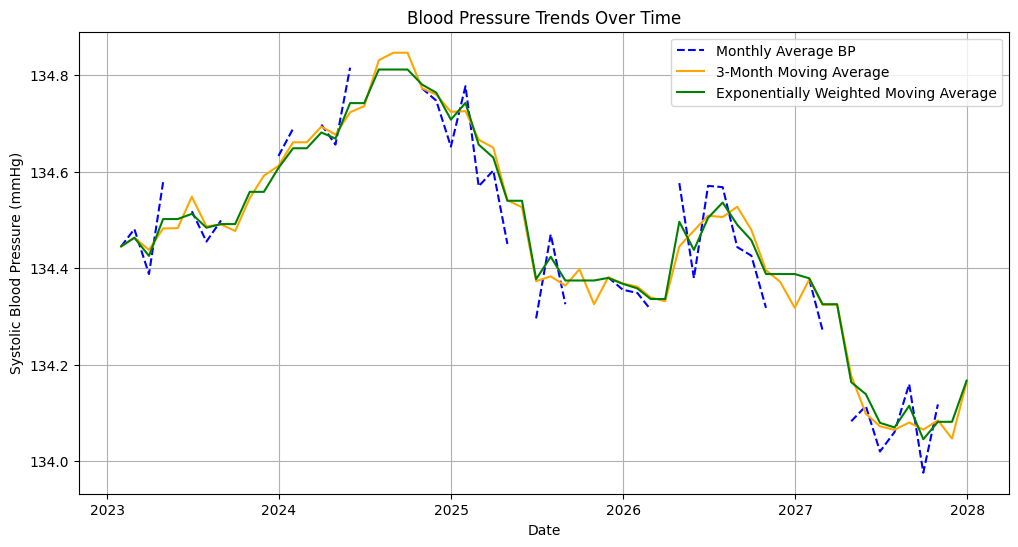

In [23]:
# Plot the original and smoothed blood pressure trends
plt.figure(figsize=(12, 6))

# Original monthly average blood pressure
plt.plot(monthly_bp, label='Monthly Average BP', color='blue', linestyle='--')

# 3-month moving average
plt.plot(bp_3_month_ma, label='3-Month Moving Average', color='orange')

# Exponentially weighted moving average (optional)
plt.plot(bp_ewm, label='Exponentially Weighted Moving Average', color='green')
plt.title('Blood Pressure Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend()
plt.grid(True)

# Display
plt.show()

Statistical Modelling Tasks: 

The predictors chosen were: : Use age, bmi, smoking, and diabetes as predictors.
The target variable: bp_systolic.

In [8]:
%pip install statsmodels
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 38.9 MB/s eta 0:00:00a 0:00:01
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
df_baseline = pd.read_csv('patient_baseline.csv', delimiter='\t')

# Select features and target variable from the baseline data
X = df_baseline[['age', 'bmi', 'smoking', 'diabetes']]
y = df_baseline['bp_systolic']

# Add a constant term to the feature matrix: 
X = sm.add_constant(X)

# Fitting the OLS model: 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Wed, 06 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        09:41:57   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

Looking at the summary of the OLS output, we can see that all the predictors are statistically significant as they all have p values <0.05. 
Further, we can look at the model fit and diagnostics by looking at the residual and QQ plots.

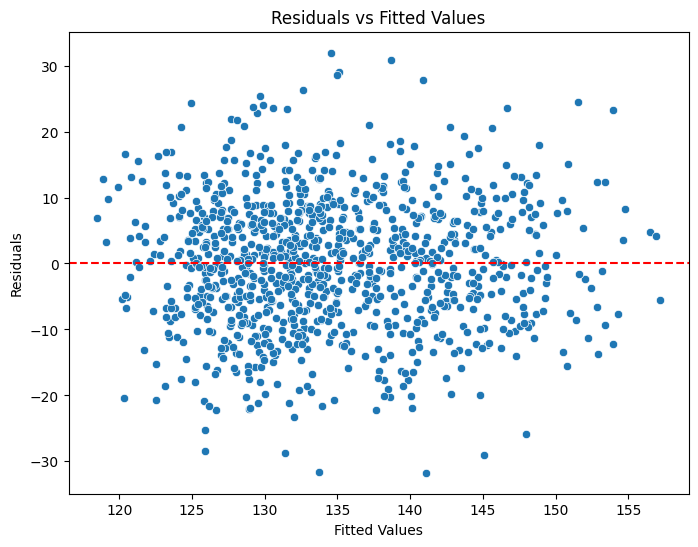

In [19]:
# Plot residuals vs fitted values
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

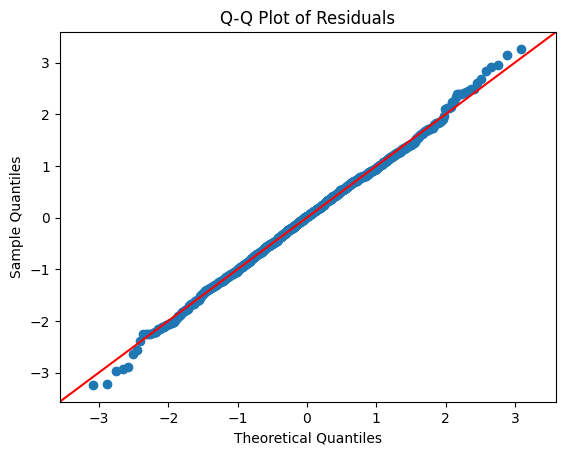

In [20]:
# Q-Q plot for normality of residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [21]:
# Fit the model with robust standard errors (HC3)
model_robust = model.get_robustcov_results(cov_type='HC3')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Wed, 06 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        09:42:08   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

2. Fitting a glm to see model treatment effectiveness
	•	Target Variable: outcome (treatment success).
	•	Predictors: Baseline characteristics (age, bmi, smoking, diabetes) and adherence.

In [22]:
df_treatment = pd.read_csv('patient_treatment.csv', delimiter='\t')


# Select predictors and target for GLM
X_glm = df_treatment[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y_glm = df_treatment['outcome']

# Add constant to predictors
X_glm = sm.add_constant(X_glm)


In [16]:
# Fit GLM model with binomial family
glm_model = sm.GLM(y_glm, X_glm, family=sm.families.Binomial()).fit()
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Wed, 06 Nov 2024   Deviance:                       1312.8
Time:                        09:39:29   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

Looking at the GLM results, we can interpret the following: 
The sonstant (Intercept): The coefficient for the intercept is approximately -1.268, with a p-value of 0.066, which is marginally above the typical significance threshold (0.05). This indicates that, when all predictors are zero, the log odds of treatment success is slightly negative but not strongly significant.
Age: The coefficient for age is 0.0027 with a high p-value of 0.565, indicating that age does not have a statistically significant effect on the odds of treatment success.
BMI: The coefficient for BMI is 0.0297, with a p-value of 0.036, which is below 0.05. This suggests that BMI is a statistically significant predictor of treatment success. A positive coefficient implies that as BMI increases, the log odds (and therefore the odds) of treatment success increase.
Smoking: The coefficient for smoking is -0.3887, with a p-value of 0.055, which is slightly above the 0.05 threshold, suggesting a weakly significant negative relationship. Smokers might have lower odds of treatment success, but the effect is not strongly significant.
Diabetes: The coefficient for diabetes is -0.4887, with a p-value of 0.004, indicating a statistically significant effect. The negative coefficient suggests that patients with diabetes have lower odds of treatment success compared to non-diabetic patients.
Adherence: The coefficient for adherence is 0.1221, with a high p-value of 0.855, indicating that adherence does not have a statistically significant effect on treatment success in this model.

In [26]:
# Calculate odds ratios and confidence intervals
odds_ratios = np.exp(glm_model.params)
conf_int = np.exp(glm_model.conf_int())

# Display odds ratios and confidence intervals
print("Odds Ratios:\n", odds_ratios)
print("\n95% Confidence Intervals:\n", conf_int)

# Compare residual deviance with null deviance
print(f"Residual Deviance: {glm_model.deviance}")
print(f"Null Deviance: {glm_model.null_deviance}")

Odds Ratios:
 const        0.281360
age          1.002744
bmi          1.030101
smoking      0.677929
diabetes     0.613448
adherence    1.129833
dtype: float64

95% Confidence Intervals:
                   0         1
const      0.072687  1.089105
age        0.993428  1.012147
bmi        1.001936  1.059058
smoking    0.456134  1.007574
diabetes   0.438726  0.857752
adherence  0.305350  4.180529
Residual Deviance: 1312.832088524959
Null Deviance: 1331.9768185036041


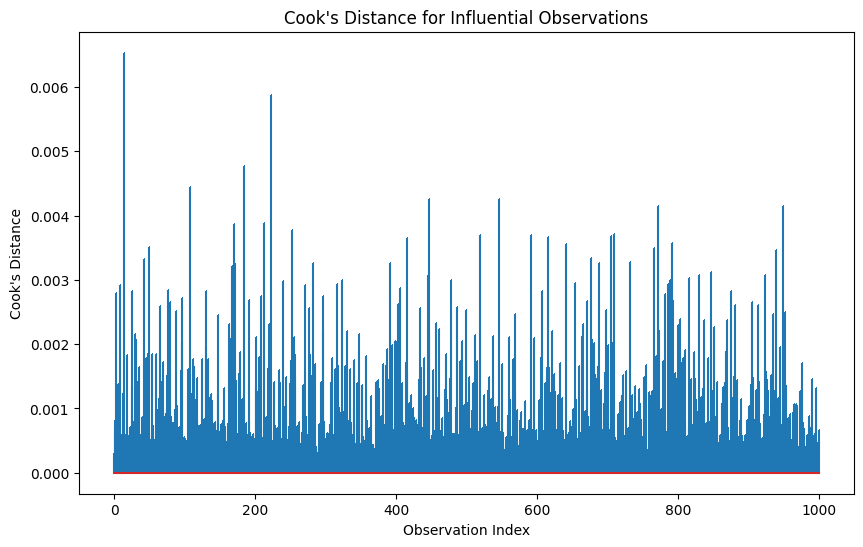

In [25]:
# Check for influential observations
influence = glm_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Plotting Cook's distance to identify any influential points
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Influential Observations")
plt.show()


The odds ratio for BMI is approximately 1.03, indicating a small increase in the odds of treatment success for each unit increase in BMI; he odds ratio for smoking is around 0.68, suggesting that smokers have reduced odds of treatment success, aligning with the negative coefficient; the odds ratio for diabetes is 0.61, confirming that diabetic patients have lower odds of treatment success compared to non-diabetic patients. The confidence intervals for the odds ratios reinforce the interpretation of the coefficients. For instance:
- BMI has a 95% confidence interval above 1 (1.001 to 1.059), which suggests a robust positive effect on treatment success.
- Diabetes has a confidence interval below 1 (0.439 to 0.858), reinforcing a strong negative effect.

The plot of Cook’s Distance shows that most observations have low Cook’s distances, with no points standing out as highly influential. This indicates that there are no strong outliers or influential data points significantly affecting the model fit.
